# BE - Benign Equivalized

In [1]:
import numpy as np
from numpy import genfromtxt, argmax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, mean_absolute_error, matthews_corrcoef, roc_curve, auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (27, 10)
# plt.rcParams["xtick.labelsize"] = 10
sns.set_context('paper', font_scale=2)

In [2]:
def calculate_classifications(y_p, y, a): #calculate correct and wrong classifications by attack category
    y_p = y_p.flatten()
    df= pd.DataFrame({'pred':y_p, 'label':y, 'attack':a})
    df['misclassification'] = df.apply(f, axis=1)
    df = df[df['attack']!='Benign']
    attacks = df['attack'].unique()
    att_dic_w = dict((n, 0) for n in attacks)
    att_dic_c = att_dic_w.copy()
    count_series = df.groupby(['attack', 'misclassification']).size()
    print(count_series)
    for key in attacks:
        counts = count_series.get(key).to_list()
        print(counts)
        if count_series.get(key).get(0) == None:
            counts.insert(0,0)
        elif count_series.get(key).get(1) == None:
            counts.insert(1,0)
        att_dic_w[key] = counts[1]
        att_dic_c[key] = counts[0]
    return att_dic_w, att_dic_c

def plot_roc_auc(y_true, y_pred):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    nfpr, ntpr, thresholds = roc_curve(y_true, ns_probs)
    ns_auc = auc(nfpr, ntpr)
    lr_auc = auc(fpr, tpr)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    print('Logistic: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='0.5')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_attack_classifications(att_dic_w, att_dic_c): #plot correct and wrong classifications by attack category
    width = 0.4
    keys = att_dic_w.keys()
    values_w = att_dic_w.values()
    values_c = att_dic_c.values()
    x = np.arange(len(keys))
    fig, ax = plt.subplots()
    r1 = ax.bar(x - width/2, values_w, width, label = "Misclassified")
    r2 = ax.bar(x + width/2, values_c, width, label = "Correct Classification")
    ax.set_ylabel('Count')
    ax.set_xlabel('Attack')
    ax.set_title('Classification by Attack')
    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.legend()
    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
#     plt.rcParams["figure.figsize"] = (30, 10)
#     plt.rcParams["xtick.labelsize"] = 10
    plt.show()
    
#https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
def attack_report(y_p, y, a):
    att_dic_w, att_dic_c = calculate_classifications(y_p, y, a)
    plot_attack_classifications(att_dic_w, att_dic_c)


def f(row):
    if row['pred'] != row['label']:
        val = 1
    else: val = 0
    return val
    
def print_cm(y_test,y_pred_round): #show confusion matrix
    cm = confusion_matrix(y_test,y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Anomaly'])
    disp = disp.plot(include_values=True, cmap = 'Blues')
    print(cm)
#     plt.rcParams["figure.figsize"] = (30, 10)
    plt.show()
    
def print_metrics(y_test,y_pred_round): #print basic metrics
    f1 = f1_score(y_test, y_pred_round, average='binary')
    acc = accuracy_score(y_test, y_pred_round)
    prec = precision_score(y_test, y_pred_round, average='binary')
    recall = recall_score(y_test, y_pred_round, average = 'binary')
    mcc = matthews_corrcoef(y_test, y_pred_round)
    print('accuracy: ',acc)
    print('f1: ', f1)
    print('precision: ', prec)
    print('recall: ', recall)
    print('mcc: ', mcc)
    
def training_report(train_model): #plot acc and loss vs epochs
    loss_vals = train_model.history['loss']
    epochs = range(1, len(loss_vals)+1)
#     plt.rcParams["figure.figsize"] = (30, 10)
    validation_loss = train_model.history['val_loss']
    plt.plot(epochs, loss_vals, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_vals = train_model.history['binary_accuracy']
    validation_acc = train_model.history['val_binary_accuracy']
    plt.plot(epochs, acc_vals, label='Training Accuracy')
    plt.plot(epochs, validation_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def test_report(y_test,y_pred_round):
    print_cm(y_test,y_pred_round)
    print_metrics(y_test,y_pred_round)

# Data Index

- X_train, y_train - Training data from 3 datasets 
- X_test, y_test - Test data from 3 datasets 
- X_val, y_val - Validation data from 3 datasets 
- X_1, y_1 - 1 datasets, test phase 2 data

In [3]:
folder = 'rboa\\'
saveModel = 'RF_Models\\'
filename = 'rboa-e11.pkl'

X_train = np.load(folder+'X_train.npy')
y_train = np.load(folder+'y_train.npy')

clf = RandomForestClassifier(n_estimators=500, min_samples_split=8, min_samples_leaf=12, max_features='sqrt', max_depth=15, verbose=2, n_jobs=2)

In [4]:
clf.fit(X_train, y_train)
pickle.dump(clf, open(saveModel+filename, 'wb'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  7.3min


building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 31.0min


building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500


[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 73.7min


building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 101.4min finished


# Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:   43.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.0min finished


Best Threshold=0.499126
Logistic: ROC AUC=1.000
Logistic: ROC AUC=0.500


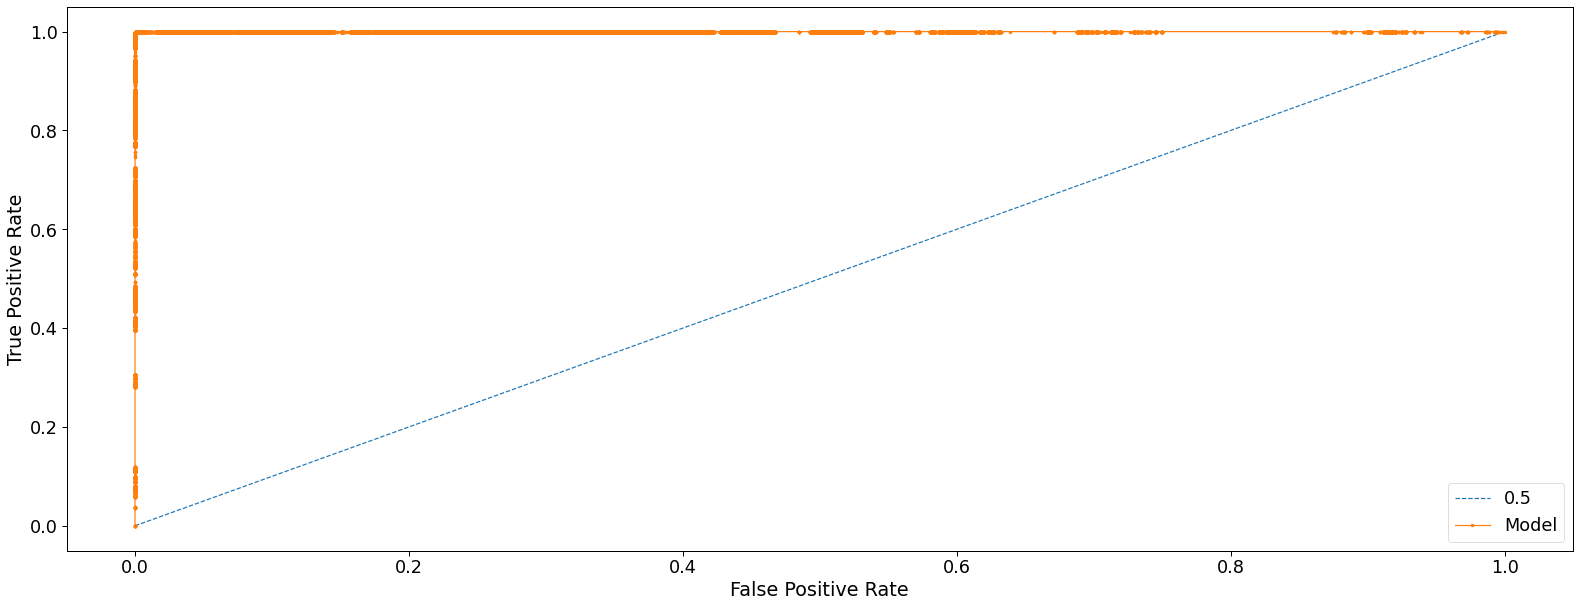

[[1277049    1206]
 [    259 1277996]]


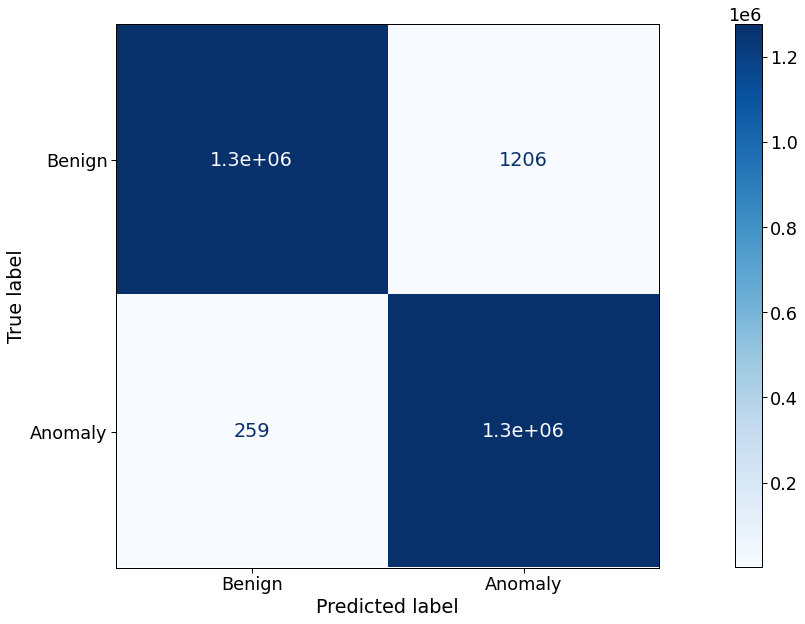

accuracy:  0.9994269531509754
f1:  0.9994271653443244
precision:  0.999057224738548
recall:  0.999797380021983
mcc:  0.9988541804196721


In [5]:
X_1 = np.load(folder+'X_test.npy')
y_1 = np.load(folder+'y_test.npy')

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)

# Full Test Set

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   25.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  5.7min finished


Best Threshold=0.002588
Logistic: ROC AUC=0.897
Logistic: ROC AUC=0.500


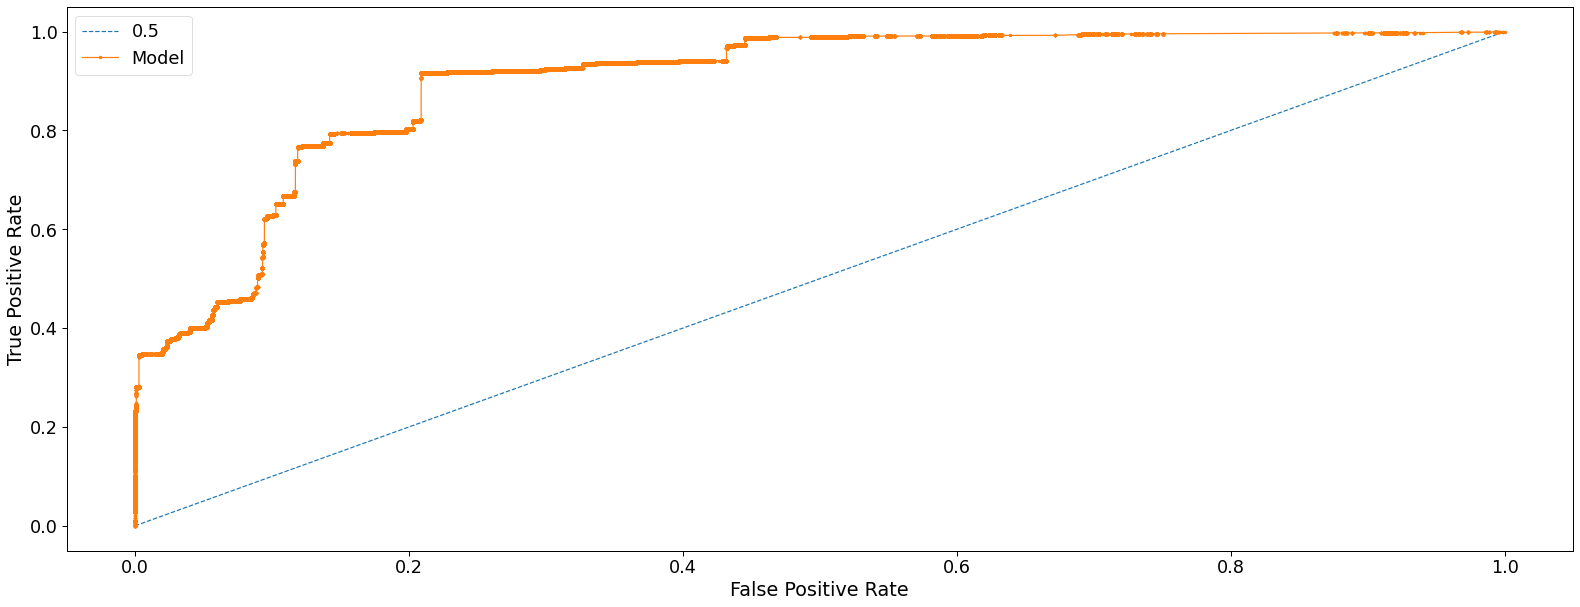

[[10361299     9447]
 [ 1678769   545735]]


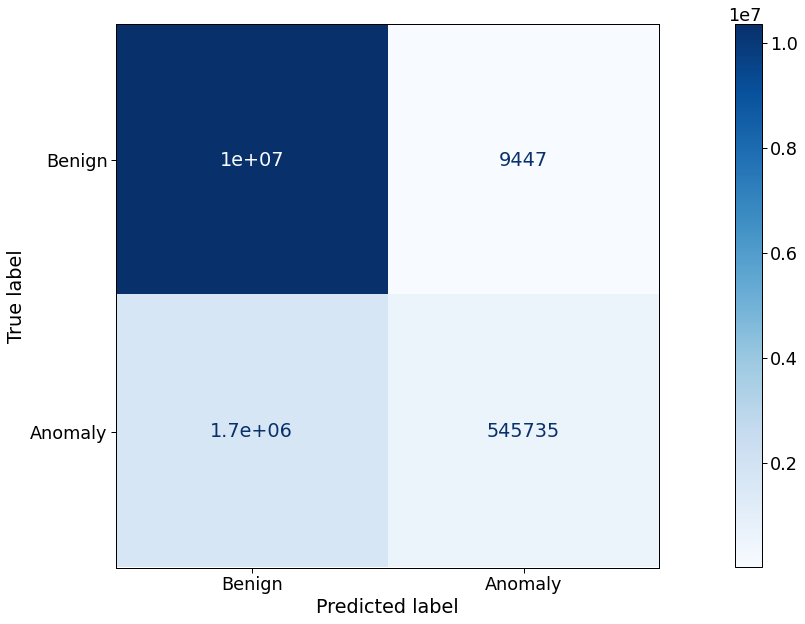

accuracy:  0.8659640737579644
f1:  0.3926594586582801
precision:  0.9829839584136373
recall:  0.2453288463405775
mcc:  0.4540696528959622
attack                    misclassification
Bot                       1                     143097
Brute Force -Web          0                          6
                          1                       2088
Brute Force -XSS          0                          5
                          1                        890
DDOS attack-HOIC          1                    1080858
DDoS attacks-LOIC-HTTP    1                     280337
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      21949
                          1                      92377
SQL Injection             1                     

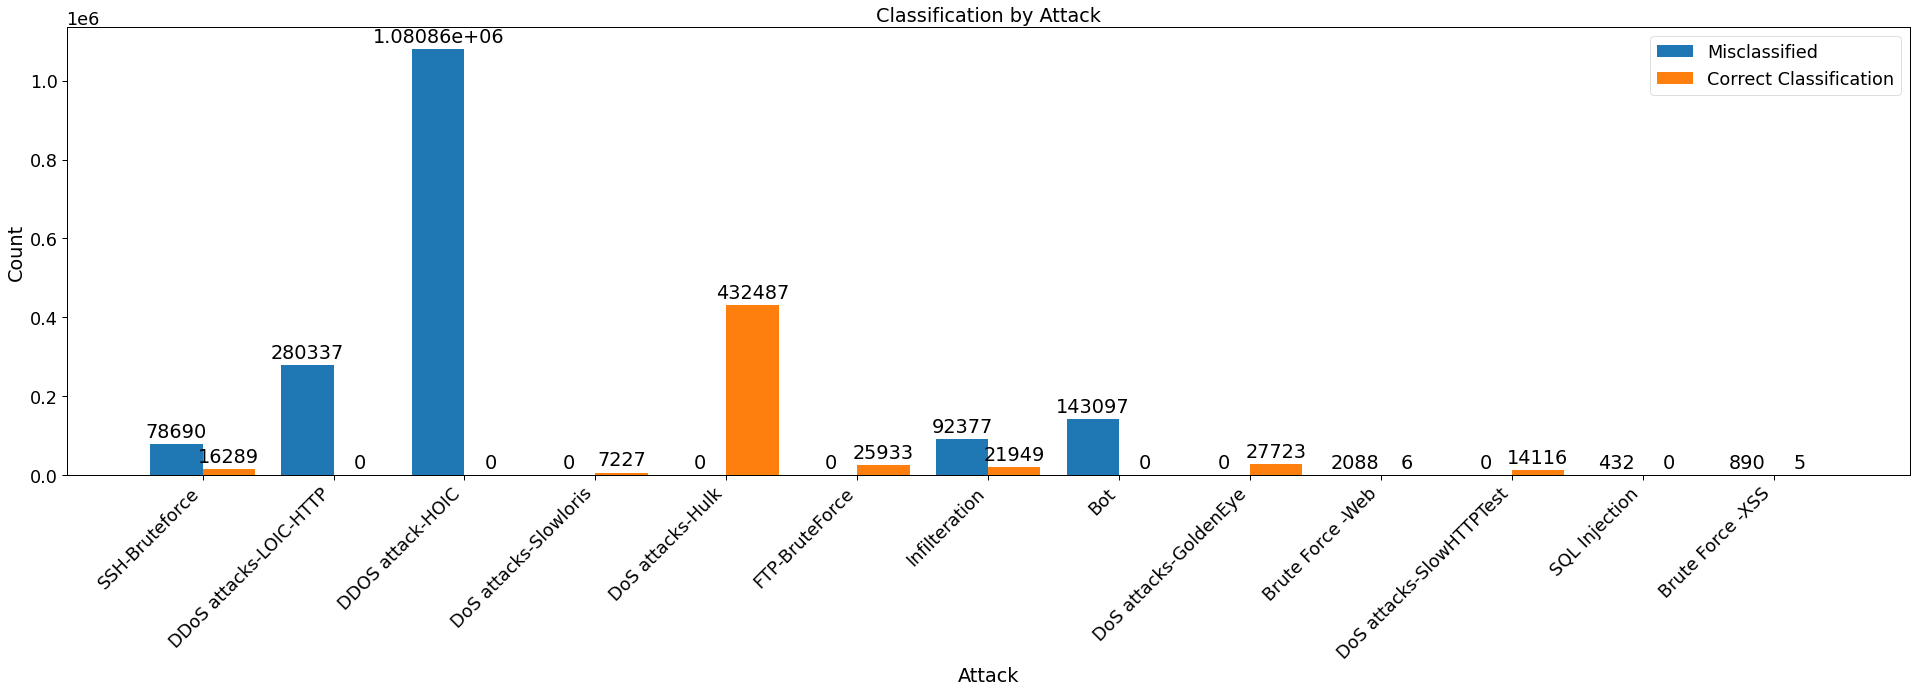

In [6]:
X_1 = np.load(folder+'X_1.npy')
y_1 = np.load(folder+'y_1.npy')
a_1 = np.load(folder+'a_1.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)

# Full Test Set with Threshold

Best Threshold=0.002588
[[8203268 2167478]
 [ 187060 2037444]]


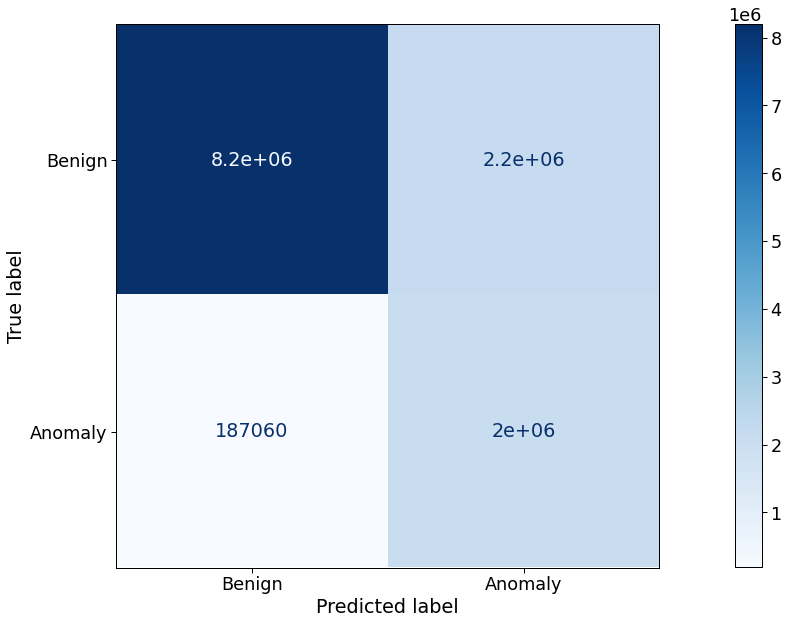

accuracy:  0.8130614318890058
f1:  0.6337872152195235
precision:  0.4845378820344349
recall:  0.9159093442852879
mcc:  0.571633068016837
attack                    misclassification
Bot                       0                     143097
Brute Force -Web          0                       1808
                          1                        286
Brute Force -XSS          0                        765
                          1                        130
DDOS attack-HOIC          0                    1080857
                          1                          1
DDoS attacks-LOIC-HTTP    0                     152361
                          1                     127976
DoS attacks-GoldenEye     0                      27723
DoS attacks-Hulk          0                     432487
DoS attacks-SlowHTTPTest  0                      14116
DoS attacks-Slowloris     0                       7227
FTP-BruteForce            0                      25933
Infilteration             0                      

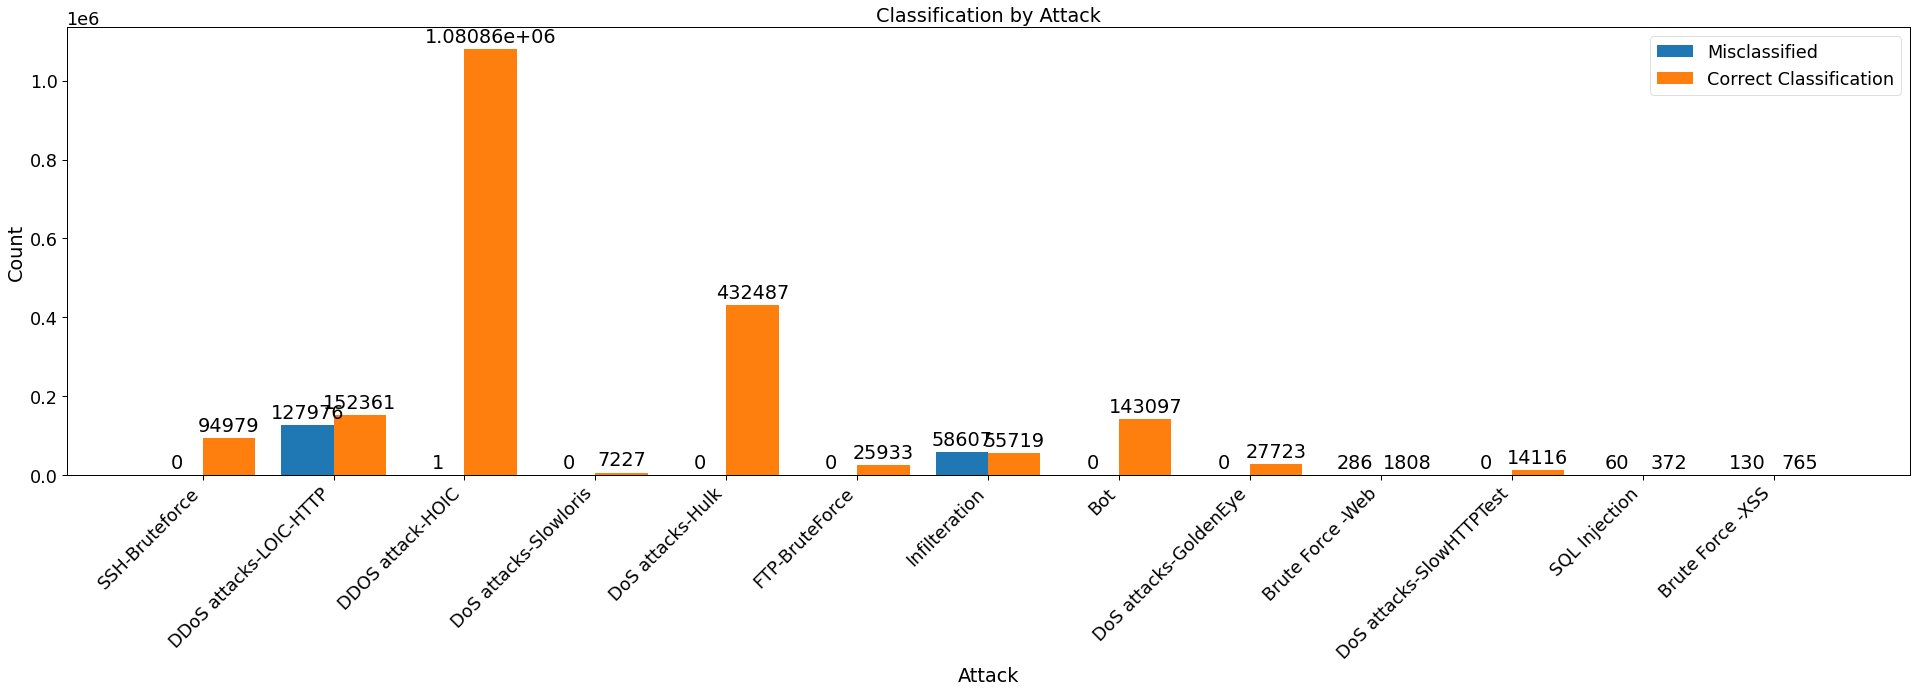

In [7]:
print('Best Threshold=%f' % (best_thresh))
y_pred2 = np.where(y_pred_o > best_thresh, 1, 0)
test_report(y_1 ,y_pred2)
attack_report(y_pred2, y_1, a_1)

# Test Set AR

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   19.3s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  4.4min finished


Best Threshold=0.307084
Logistic: ROC AUC=0.953
Logistic: ROC AUC=0.500


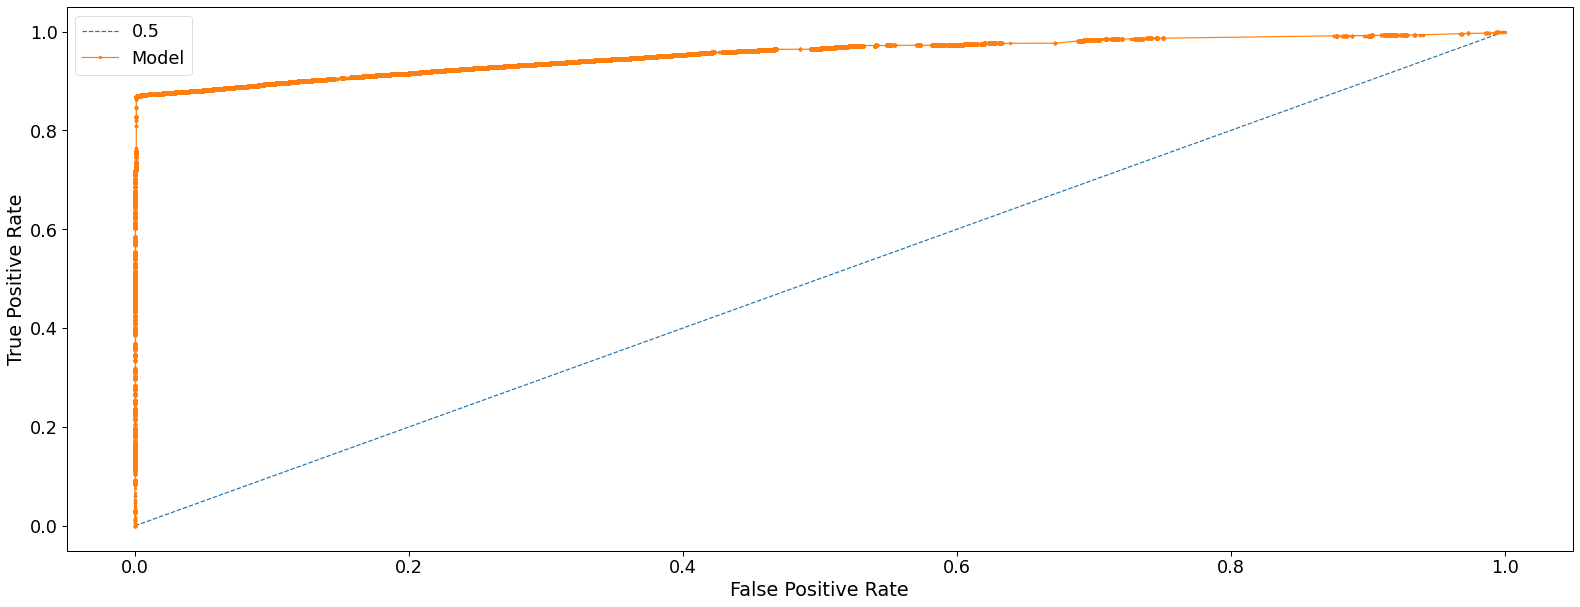

[[10361299     9447]
 [  174477   545735]]


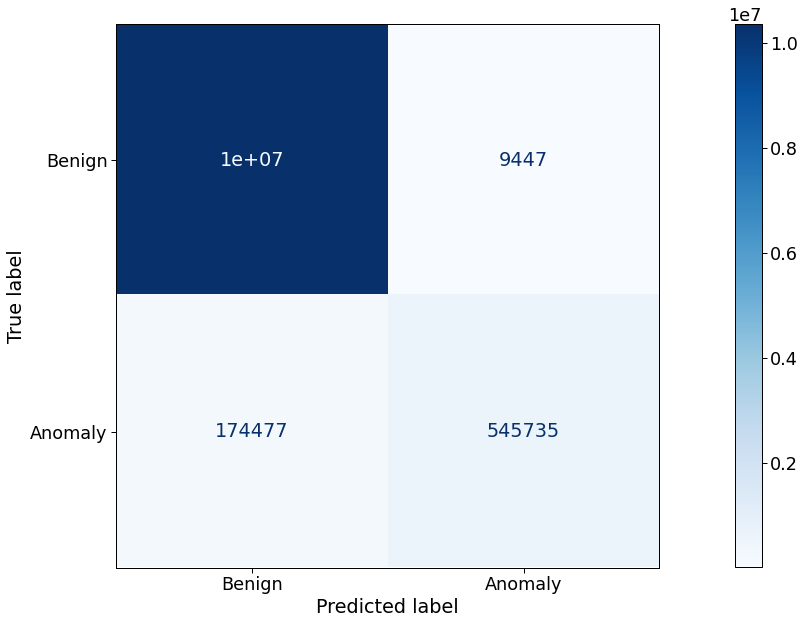

accuracy:  0.9834167616539528
f1:  0.8557904459327862
precision:  0.9829839584136373
recall:  0.757742164807029
mcc:  0.8552306783501136
attack                    misclassification
Brute Force -Web          0                         6
                          1                      2088
Brute Force -XSS          0                         5
                          1                       890
DoS attacks-GoldenEye     0                     27723
DoS attacks-Hulk          0                    432487
DoS attacks-SlowHTTPTest  0                     14116
DoS attacks-Slowloris     0                      7227
FTP-BruteForce            0                     25933
Infilteration             0                     21949
                          1                     92377
SQL Injection             1                       432
SSH-Bruteforce            0                     16289
                          1                     78690
dtype: int64
[16289, 78690]
[7227]
[432487]
[25933]
[21949, 923

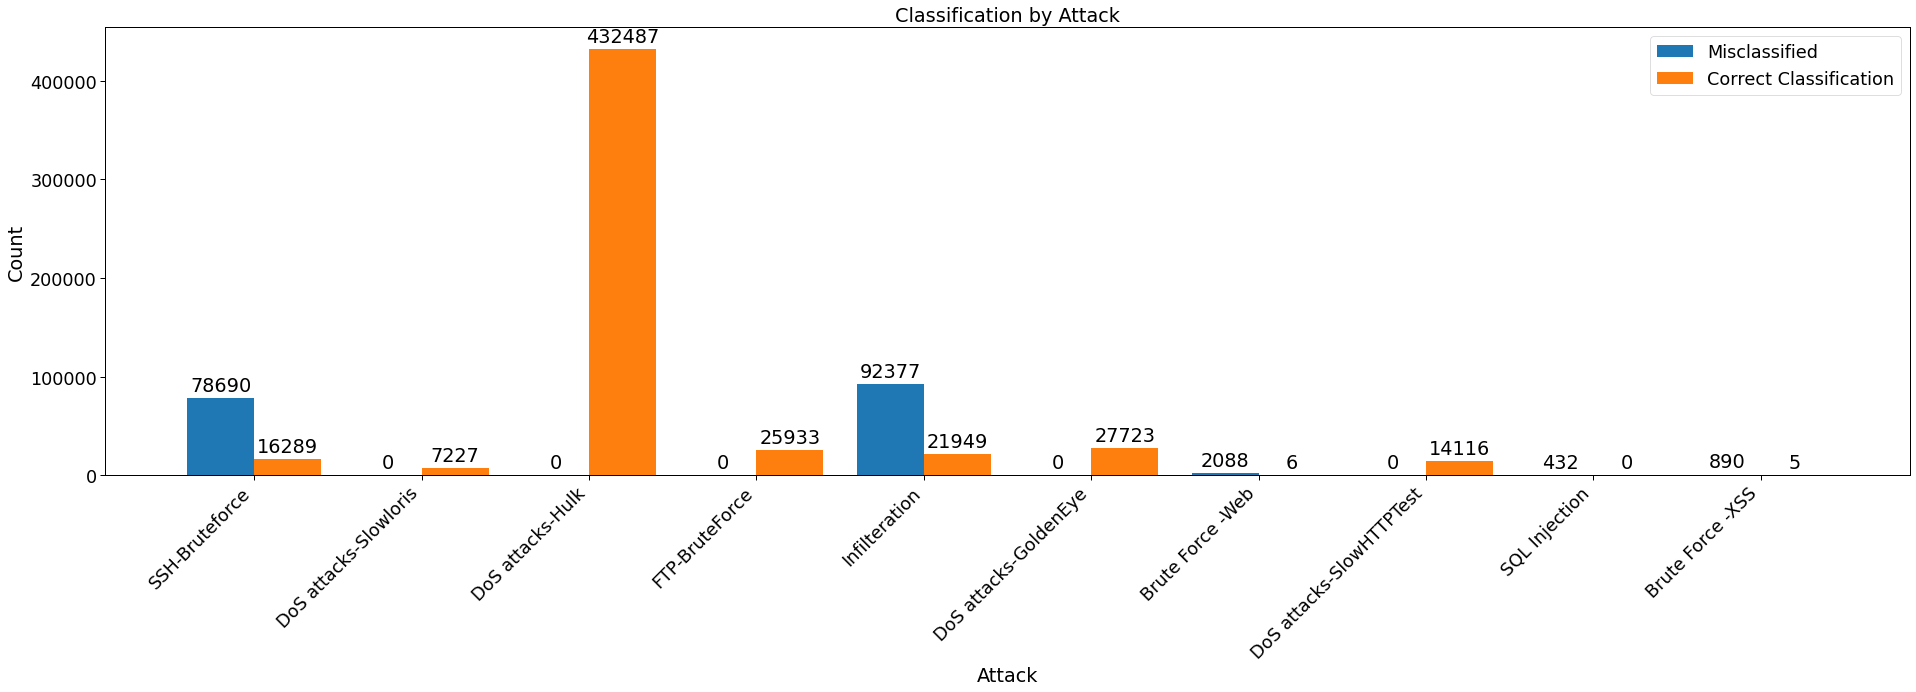

In [8]:
X_1 = np.load(folder+'X_1_ar.npy')
y_1 = np.load(folder+'y_1_ar.npy')
a_1 = np.load(folder+'a_1_ar.npy',allow_pickle=True)

y_pred_o = clf.predict_proba(X_1)[:,1]

fpr, tpr, thresholds = roc_curve(y_1, y_pred_o)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))
plot_roc_auc(y_1, y_pred_o)
y_pred_oround = np.rint(y_pred_o)
test_report(y_1,y_pred_oround)
attack_report(y_pred_oround, y_1, a_1)